### Notebook: Regex approach

Use simple/basic regex apprach to extract the metaphors from the Interveiws.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('averaged_perceptron_tagger')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

# TODO: Words following each other, not any word from the sentence?! (should be fine after removing stop_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathieu26/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Basic Regex:**

To find the conceptual metaphors mentioning "Inflation", we will try to find sentences which contains the word "Inflation" followed or preceeded by any word from a corpus given by the paper: Inflation Metaphor in Contemporary American English.

The corpus contains the 9 roots mentioned in the paper. 

**Choice between Stemming or Lemmatization:**

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [2]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod = 2

In [3]:
# Functions:
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos 
def tokenize(text, modulation):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences while preserving periods

    processed_sentences = []

    for sentence in sentences:
        if modulation < 2:
            # Tokenize and preprocess each sentence
            tokens = re.findall(r'\w+', sentence.lower())
            stems = []
            for token in tokens:
                lowers = abbr_or_lower(token)
                if lowers not in stop_words and re.search('[a-zA-Z]', lowers):
                    if modulation == 0:
                        stems.append(lowers)
                    elif modulation == 1:
                        stems.append(porter.stem(lowers))
            processed_sentence = " ".join(stems)
        else:
            doc = sp(sentence)
            lemmatized_tokens = []
            for token in doc:
                if token.text.strip():
                    lemmatized_tokens.append(token.lemma_)
            processed_sentence = " ".join(lemmatized_tokens)

        processed_sentences.append(processed_sentence)

    # Reconstruct the text with preserved sentence boundaries
    processed_text = " ".join(processed_sentences)

    return processed_text

def tokenize_word_list(word_list, modulation):
    processed_words = []

    for word in word_list:
        processed_word = word.lower()
        if modulation < 2:
            if modulation == 0:
                processed_words.append(processed_word)
            elif modulation == 1:
                processed_words.append(porter.stem(processed_word))
        else:
            # Apply lemmatization using spaCy
            doc = sp(word)
            lemmatized_text=[]
            for w_ in doc:
                lemmatized_text.append(w_.lemma_)
            processed_words.extend([abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)])

    return " ".join(processed_words)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def regex_matcher(text, as_words):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains "inflation" and any word from as_words
        if "inflation" in sentence.lower() and any(word in sentence.lower() for word in as_words):
            selected_sentences.append(sentence)

    return selected_sentences

def regex_matcher_word_order(text, as_words):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains "inflation" and any word from as_words
        sentence_lower = sentence.lower()
        if "inflation" in sentence_lower:
            # Split the sentence into words
            words = sentence_lower.split()

            # Check if "inflation" exists in the list of words
            inflation_indices = [i for i, word in enumerate(words) if "inflation" in word]
            
            if inflation_indices:
                inflation_index = inflation_indices[0]  # Use the first index if multiple are found
            else:
                inflation_index = None

            if inflation_index is not None:
                # Define the range of words to search around "inflation"
                search_range = range(max(0, inflation_index - 3), min(len(words), inflation_index + 4))

                search_indices = list(search_range)

                # Check if any word from as_words appears within the search range
                if any(words[idx] in as_words for idx in search_indices):
                    selected_sentences.append(sentence)

    return selected_sentences

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

def text_length_distribution(df):
    df['text_length'] = df['Answers'].apply(len)
    plt.figure(dpi=300)
    # Plot histogram with a label for the legend
    df['text_length'].hist(bins=30, color=color, label='Text Length')
    # Add title and labels
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

In [4]:
# Import dataset containing the interveiw data
df = pd.read_csv('data_complete.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 30 rows:
df = df.tail(100)

df.head()

,Date,Media,Member,Link,Information,Questions,Answers
419,2021-04-11,Interview with El País,Fabio Panetta,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Fabio Panetta, Member of the Ex...",The recovery in the euro area is still very fr...,11 April 2021[end_answer] Uncertainty has rece...
420,2021-04-09,Interview with Der Spiegel,Isabel Schnabel,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Isabel Schnabel, Member of the ...","Ms Schnabel, the global economy is only slowly...",9 April 2021[end_answer] We are closely monito...
421,2021-03-23,Interview with CNBC,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...",Let me bring you first to the increased asset ...,"23 March 2021[end_answer] As you know, the wee..."
422,2021-03-17,Q&A on Twitter,Frank Elderson,https://www.ecb.europa.eu/press/inter/date/202...,"Interview on Twitter with Frank Elderson, Memb...",Why dont you better explain your policies by i...,"17 March 2021[end_answer] Hello, this is@Frank..."
423,2021-03-17,Interview with Les Echos,Isabel Schnabel,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Isabel Schnabel, Member of the ...",There has been a delay in the supply of vaccin...,16 March 2021[end_answer] The recovery crucial...


In [5]:
# We won't need the Questions, Link column for this analysis
df = df.drop(columns=['Questions', 'Link'])
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (100, 5)


Date           0
Media          0
Member         0
Information    0
Answers        0
dtype: int64

In [6]:
# Drop the rows with missing values
df = df.dropna()
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (100, 5)


Date            97
Media           72
Member           6
Information    100
Answers        100
dtype: int64

In [7]:
#types of data
df.dtypes

Date           datetime64[ns]
Media                  object
Member                 object
Information            object
Answers                object
dtype: object

In [8]:
start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

Start date is:  2021-01


In [9]:
"""text_length_distribution(df)
# average text length
print("The mean length is: ",df['text_length'].mean())
"""

'text_length_distribution(df)\n# average text length\nprint("The mean length is: ",df[\'text_length\'].mean())\n'

In [10]:
# List of words to match: (taken from paper: Inflation Metaphor in Contemporary American English)
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy']
as_plant = ['hedge','nip']
as_animal = ['soar', 'runaway', 'rampant', 'curb', 'tame', 'rein', 'spur', 'creep', 'whip', 'gallop', 'halt', 'roar', 'hover', 'curtail', 'spawn', 'gnaw', 'hibernation']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'downward', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation

print("Length of the list of words to match: ", len(as_words))

Length of the list of words to match:  115


In [11]:
# Pre-process the list of words with the same modulation as the interviews
as_words = tokenize_word_list(as_words, mod)
as_words

'ignite fuel spark dampen stoke kindle choke stifle fan flare douse snuff erode surge subside simmer emergence ebb dilute spurt recede buoy hedge nip soar runaway rampant curb tame rein spur creep whip gallop halt roar hover curtail spawn gnaw hibernation plague worsen benign virulent debilitate bout chronically threat subdue target beat preempt vigilant ravage undermine forestall counteract eliminate ferocious ruinous clobber buster eradicate besiege thwart bash beset pace outstrip lag surpass quicken outrun bout good tug war zip overtake accelerate fast control slow trigger skyrocket rapid heat escalate decelerate ratchet unchecked readjust chug damper zoom low rise high increase reduce decline fall exceed spiral hyper upward uptick downward boost peak diminish upturn hike plummet upswe'

In [12]:
def preprocess_text(df):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_numbers(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: tokenize(row, mod)))

        df["Answers_cleaned"]=text_preproc

        return df

df = preprocess_text(df)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [13]:
# This adds the list of sentences containing the words to match in a new column
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher(x, as_words)))
df["list_regex"] = regex_match

# Reduced regex matcher
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher_word_order(x, as_words)))
df["list_regex_reduced"] = regex_match

In [14]:
df['list_regex_len'] = df['list_regex'].apply(len)
df['list_regex_reduced_len'] = df['list_regex_reduced'].apply(len)
df['text_length'] = df['Answers'].apply(len)

In [15]:
# Check results of the regex matching:
df["list_regex"].iloc[0]

['inflation be project to remain well below our target in the medium term compare with around in the United Kingdom the United States and Canada ',
 'we need more ambition to help economic activity reach its potential and see inflation converge towards our aim ',
 'if we have not intervene the tightening of financing condition would have have a negative impact on growth and inflation in Europe ',
 'with inflation projection still way below we could not accept a tightening of financing condition irrespective of its cause or origin this would have be inconsistent with our policy mandate ',
 'favourable financing condition be an intermediate target for achieve our primary objective which be inflation close to ',
 'in the United States inflation be see a return to healthy level because monetary and fiscal policy be work forcefully together ',
 'in the euro area the mediumterm inflation outlook be unsatisfactory ',
 'inflation will temporarily increase this year due to some transitory facto

/var/folders/fx/j6fbl16n4dx92c8z30z6z7fh0000gn/T/ipykernel_96392/2548845872.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

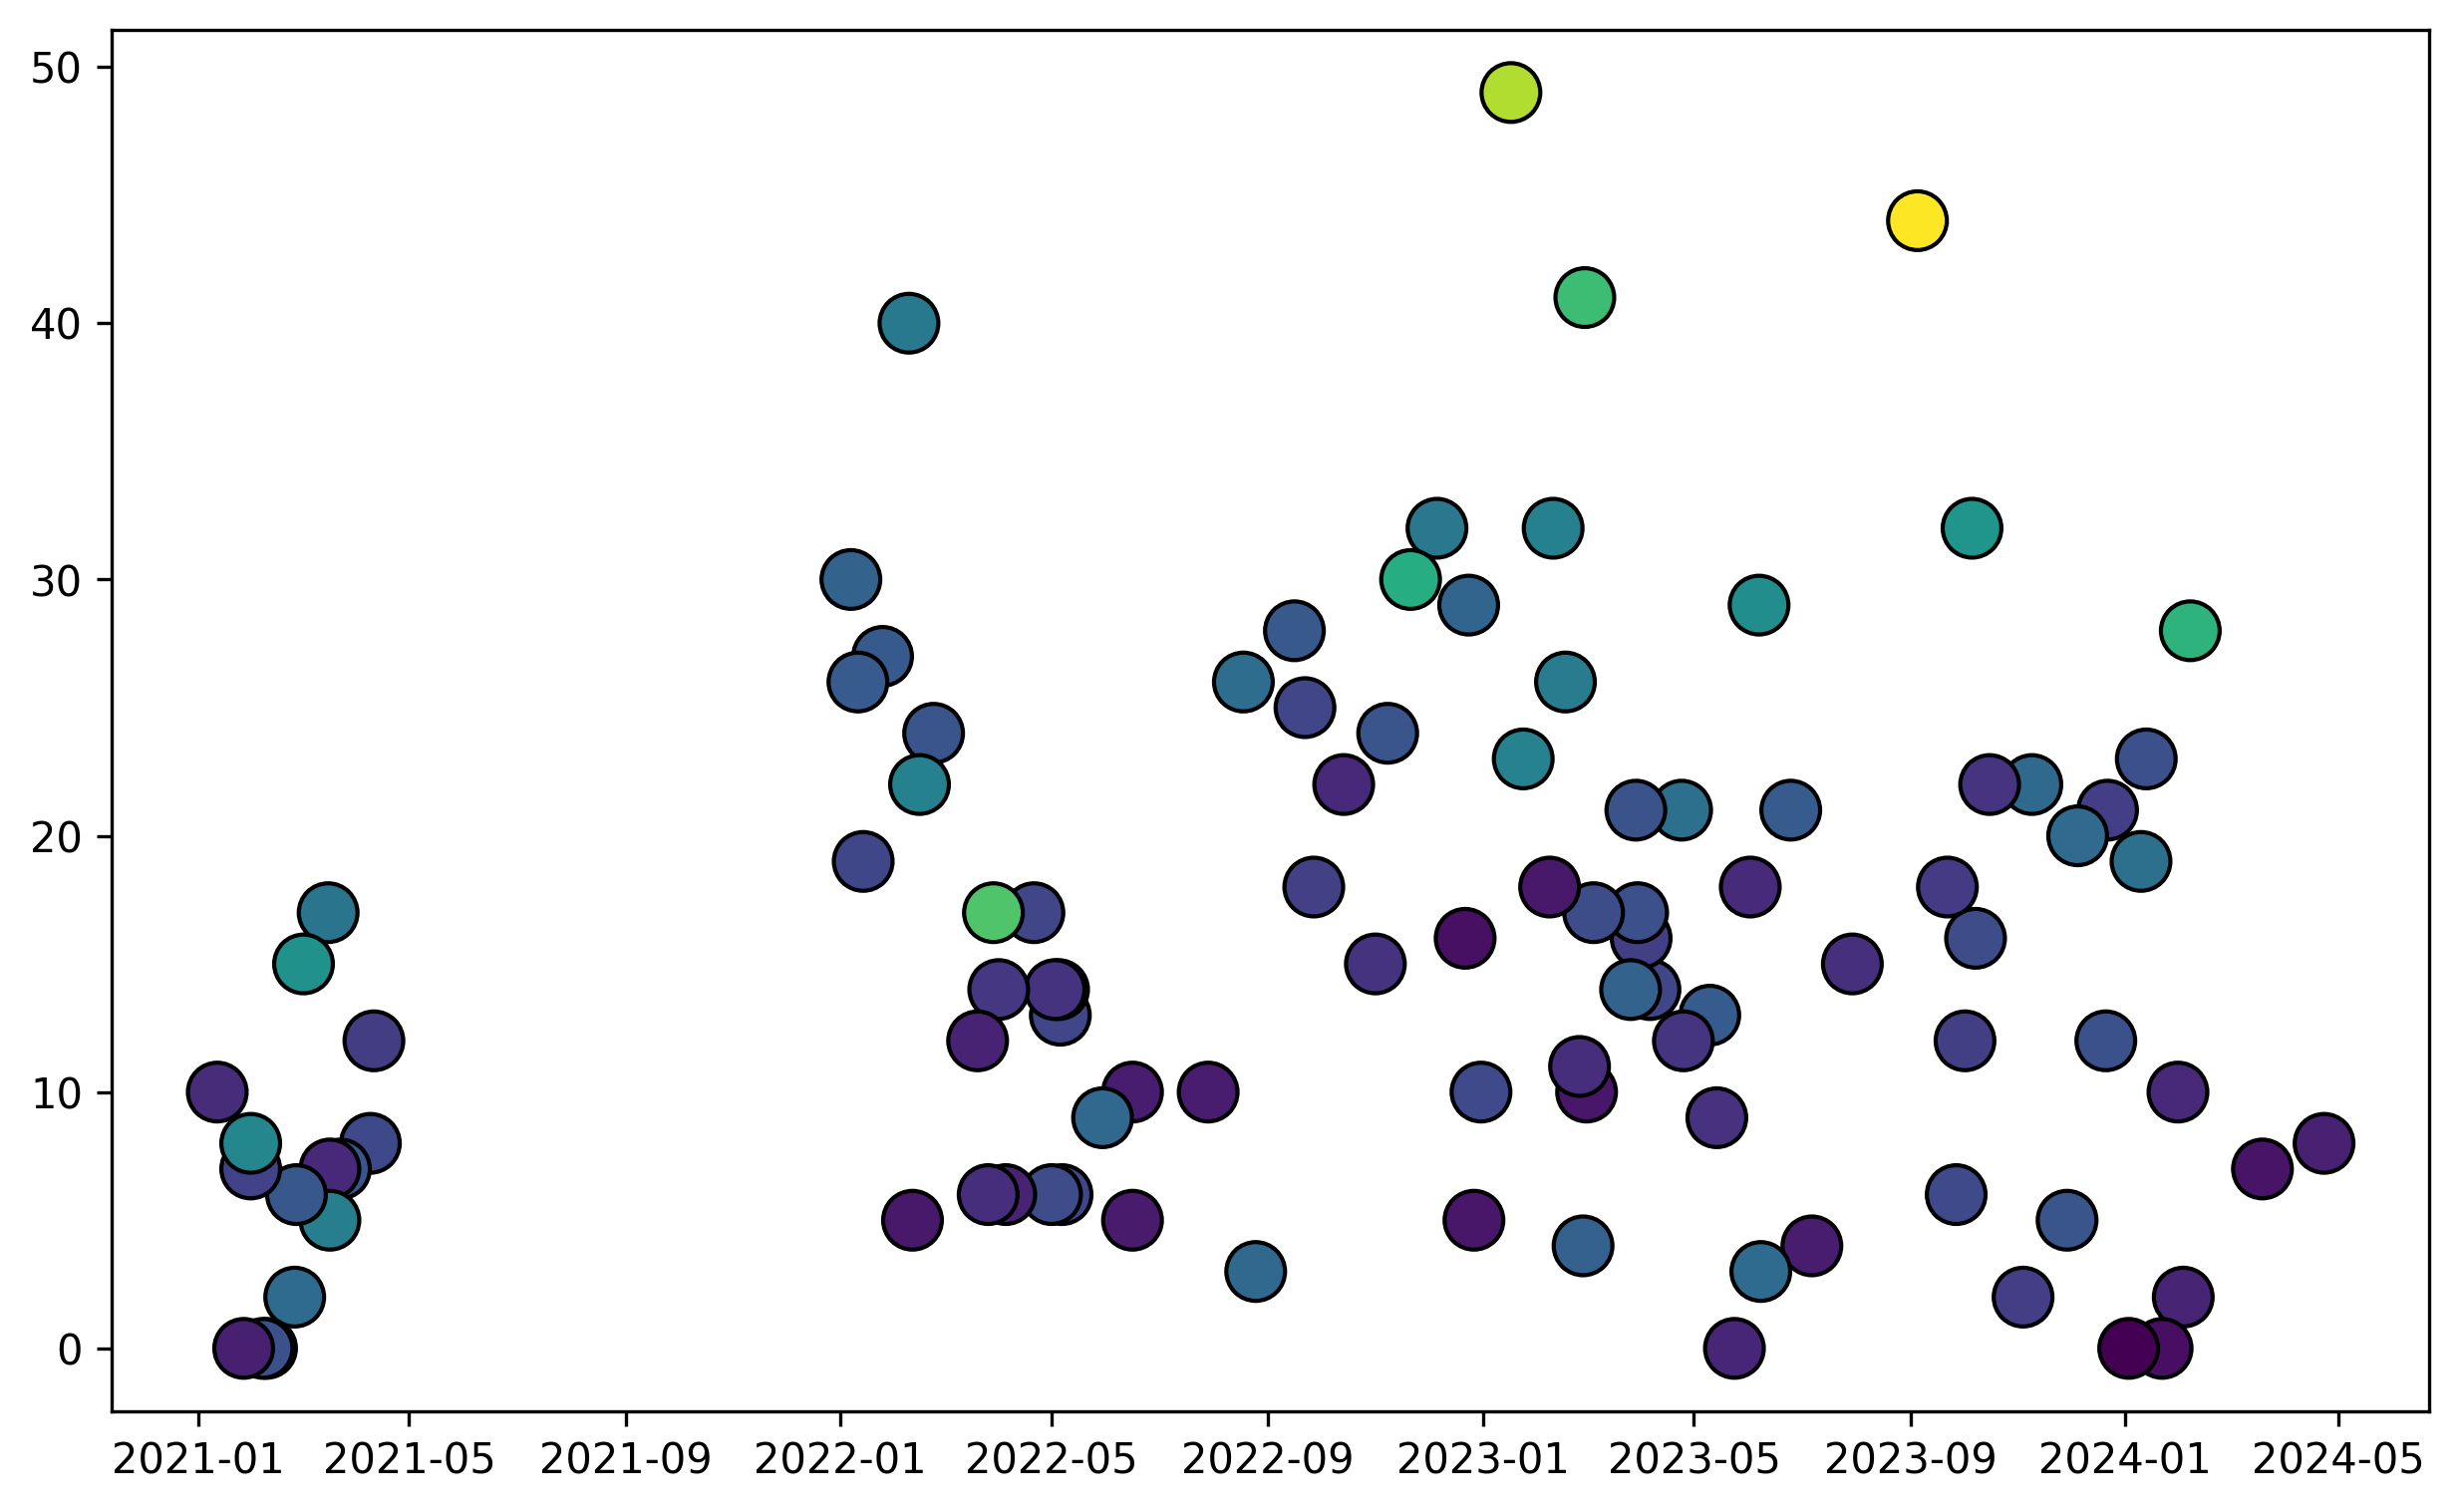

In [17]:
import matplotlib.colors as mcolors

# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(10, 6), dpi=300)
sc = plt.scatter(df['Date'], df['list_regex_len'], c=df['text_length'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['list_regex_len'], str(row['list_regex_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_868\2402241904.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_868\2402241904.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


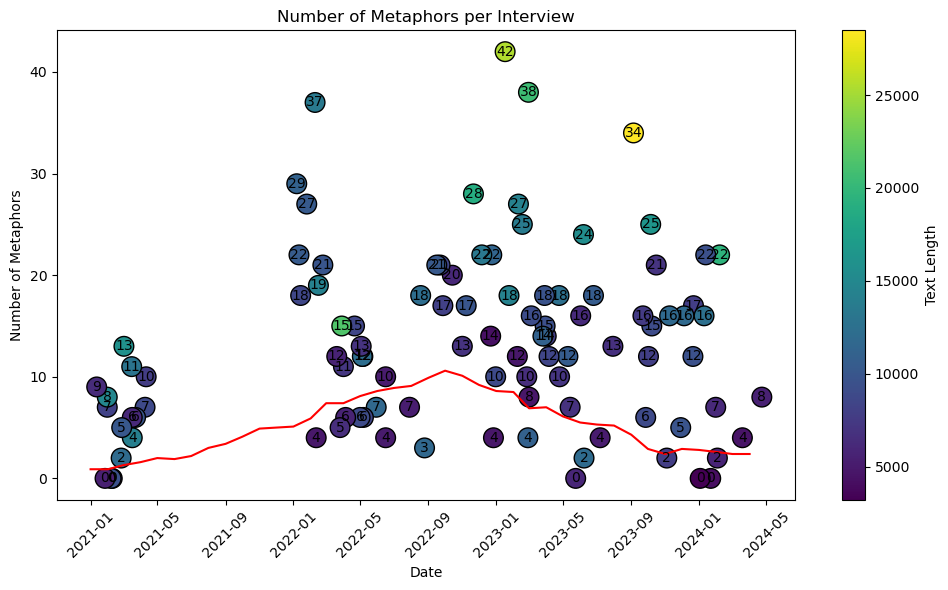

In [ ]:
import matplotlib.colors as mcolors

# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['Date'], df['list_regex_reduced_len'], c=df['text_length'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['list_regex_reduced_len'], str(row['list_regex_reduced_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview (reduced)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Save the dataframe
# df.to_csv("data_test.csv", index=False)